# Toronto COVID-19 Cases Project

Author: Adrienne Siu
Date: August 2020

# 1. Problem Definition

In this project, I will use machine learning to:
(1) Predict the outcomes of cases of COVID-19 in Toronto
(2) Find the variables that correlate most with the outcome

The dataset is available on Toronto Open Data and the version from July 29, 2020 was used: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

This dataset has been saved as 'COVID19 cases.csv'.

The three possible outcomes are: fatal, resolved (not fatal), and active.

In [50]:
# DELETE
#%qtconsole
#import pdb
#import contextlib
#with contextlib.redirect_stdout(None):
#import pixiedust

In [51]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import geopandas as gpd # for neighbourhood heat map
import seaborn as sns

# 2. Data Cleaning

In this section, I will clean the data for analysis.

In [52]:
# Path of dataset file (.csv)
covid_file_path = 'COVID19 cases.csv'

# Read the file
covid_data = pd.read_csv(covid_file_path)

In [53]:
# Display the first few rows of the dataset
covid_data.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [54]:
# Function to create a table of missing values in columns
# Function written by Nikos Tavoularis on Stack Overflow: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251
# Function comments by AS
def missing_values_table(df):
        # Count the number of missing values in each column
        mis_val = df.isnull().sum()
        # Calculate the percentage of missing values in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Put the number of missing values and % missing values in a table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns of the table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Take out columns with no missing values
        # Reorder columns with missing values in descending order
        # Round % missing values to 1 decimal place
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print summary
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return table of missing values
        return mis_val_table_ren_columns

In [55]:
# DELETE
#%%pixie_debugger
#pdb.set_trace()

In [56]:
# Create table of missing values
missing_values_table(covid_data)

Your selected dataframe has 18 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Neighbourhood Name,609,4.0
FSA,563,3.7
Age Group,27,0.2


As observed, there are only 3/18 columns with missing values. For each column, the % missing values is 4% or less. Hence, the dataset is fairly complete.

I will leave the missing values as they are for the exploratory data analysis. Later, for the modelling, I will fill some of the missing values:

The age group will be filled with median imputation, i.e. the median age group.

If neither of the FSA or the neighbourhood name are known, these will remain unknown.

If one of the FSA or the neighbourhood name is known, the other will be inferred.

In [57]:
# Look for categorical variables
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15338 entries, 0 to 15337
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     15338 non-null  int64 
 1   Assigned_ID             15338 non-null  int64 
 2   Outbreak Associated     15338 non-null  object
 3   Age Group               15311 non-null  object
 4   Neighbourhood Name      14729 non-null  object
 5   FSA                     14775 non-null  object
 6   Source of Infection     15338 non-null  object
 7   Classification          15338 non-null  object
 8   Episode Date            15338 non-null  object
 9   Reported Date           15338 non-null  object
 10  Client Gender           15338 non-null  object
 11  Outcome                 15338 non-null  object
 12  Currently Hospitalized  15338 non-null  object
 13  Currently in ICU        15338 non-null  object
 14  Currently Intubated     15338 non-null  object
 15  Ev

Apart from the patient ID, the columns are all categorical variables. I will deal with encoding for categorical variables in the modelling section.

# 3. Exploratory Data Analysis (EDA)

In this section, I will explore the data, including correlations between variables and outcomes.

In [58]:
# Number of distinct values in Neighbourhood Name, FSA, and Age Group columns
covid_data['Neighbourhood Name'].value_counts().sort_index()

Agincourt North                  82
Agincourt South-Malvern West     55
Alderwood                        44
Annex                            84
Banbury-Don Mills                39
                               ... 
Wychwood                         79
Yonge-Eglinton                   15
Yonge-St.Clair                   25
York University Heights         430
Yorkdale-Glen Park              203
Name: Neighbourhood Name, Length: 140, dtype: int64

In [59]:
covid_data['FSA'].value_counts().sort_index()

M1B    305
M1C    242
M1E    451
M1G    213
M1H     94
      ... 
M9N    355
M9P    248
M9R    382
M9V    884
M9W    434
Name: FSA, Length: 96, dtype: int64

In [60]:
covid_data['Age Group'].value_counts().sort_index()

19 and younger     964
20 to 29 Years    2230
30 to 39 Years    2182
40 to 49 Years    2156
50 to 59 Years    2424
60 to 69 Years    1646
70 to 79 Years    1064
80 to 89 Years    1538
90 and older      1107
Name: Age Group, dtype: int64

In [61]:
entry_vc = covid_data[covid_data['Outcome']=='FATAL']['Age Group'].value_counts().sort_index()
entry = entry_vc.index.tolist()
print(entry)

['19 and younger', '20 to 29 Years', '30 to 39 Years', '40 to 49 Years', '50 to 59 Years', '60 to 69 Years', '70 to 79 Years', '80 to 89 Years', '90 and older']


In [62]:
# Function to create a bar chart of a column variable
def create_bar_chart(column_name):
    # Get the count of each unique entry
    entry_vc = covid_data[column_name].value_counts().sort_index()
    # Get the unique entries and put them in a list
    entry = entry_vc.index.tolist()
    # Bar graphs of each variable
    fig = plt.figure()
    plt.barh(entry, entry_vc)
    # Invert the y-axis so that the order of the entries is from top to bottom
    plt.gca().invert_yaxis()
    plt.title('Number of COVID-19 Cases By ' + column_name)
    plt.show()

In [63]:
# Function to obtain filtered entries in dataset
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry is a string for the entry to be filtered
#        sort_flag is a string flag for whether the tick labels should be ordered by name
# Ex. To filter only the fatal outcomes, filter_column = 'Outcome' and filter_entry = 'FATAL'
# Returns entries and value counts for the specific column after filtering
def get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry, sort_flag):
    if sort_flag == 'yes':
        # Get the count of each unique entry (ordered by name)
        entry_vc = covid_data[covid_data[filter_column]==filter_entry][column_name].value_counts().sort_index()
        print('sort flag yes')
    else:
        # Get the count of each unique entry (ordered from highest to lowest count)
        entry_vc = covid_data[covid_data[filter_column]==filter_entry][column_name].value_counts()
    # Get the unique entries and put them in a list
    entry = entry_vc.index.tolist()    
    return entry, entry_vc

In [64]:
# Function to create a bar chart of a column variable with filters applied
# Stack by outcome: active, fatal, resolved
# Input: column_name is a string for the name of the column, e.g. 'Outbreak', 'Age Group'
#        filter_column is a string for the column to be filtered
#        filter_entry_list is a list of strings for entries to be filtered
#        sort_flag is a string flag for whether the tick labels should be ordered by name
def create_filtered_bar_chart(column_name, filter_column, filter_entry_list, fig_size, sort_flag):
    # Initialize lists of entries and value counts after filtering
    entry_list = []
    entry_vc_list = []
    
    # Figure size
    if fig_size == 'large':
        fig = plt.figure(figsize=(20,30))
    else:
        fig = plt.figure()

    # Loop through entries to be filtered
    for i in range(len(filter_entry_list)):
        # Entries and value counts for each filter
        entry, entry_vc = get_filtered_entries_and_value_counts_from_column(column_name, filter_column, filter_entry_list[i], sort_flag)
        # Append to list
        entry_list.append(entry)
        entry_vc_list.append(entry_vc)
        # Create a bar stacked for each filtered entry, e.g. 'Fatal', 'Active', 'Resolved'
        plt.barh(entry_list[i], entry_vc_list[i])

    # Invert the y-axis so that the order of the entries is from top to bottom
    plt.gca().invert_yaxis()
    plt.title('Number of COVID-19 Cases By ' + column_name)
    plt.legend(filter_entry_list)
    plt.show()

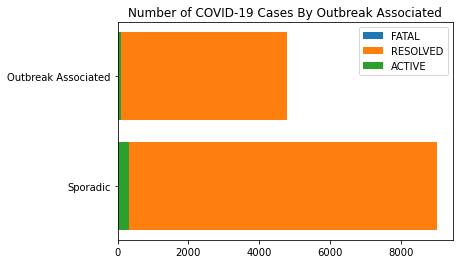

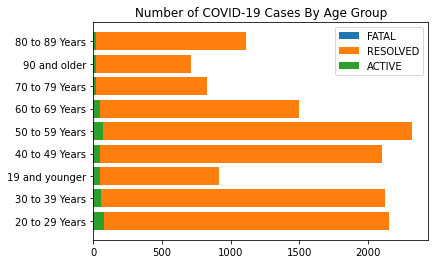

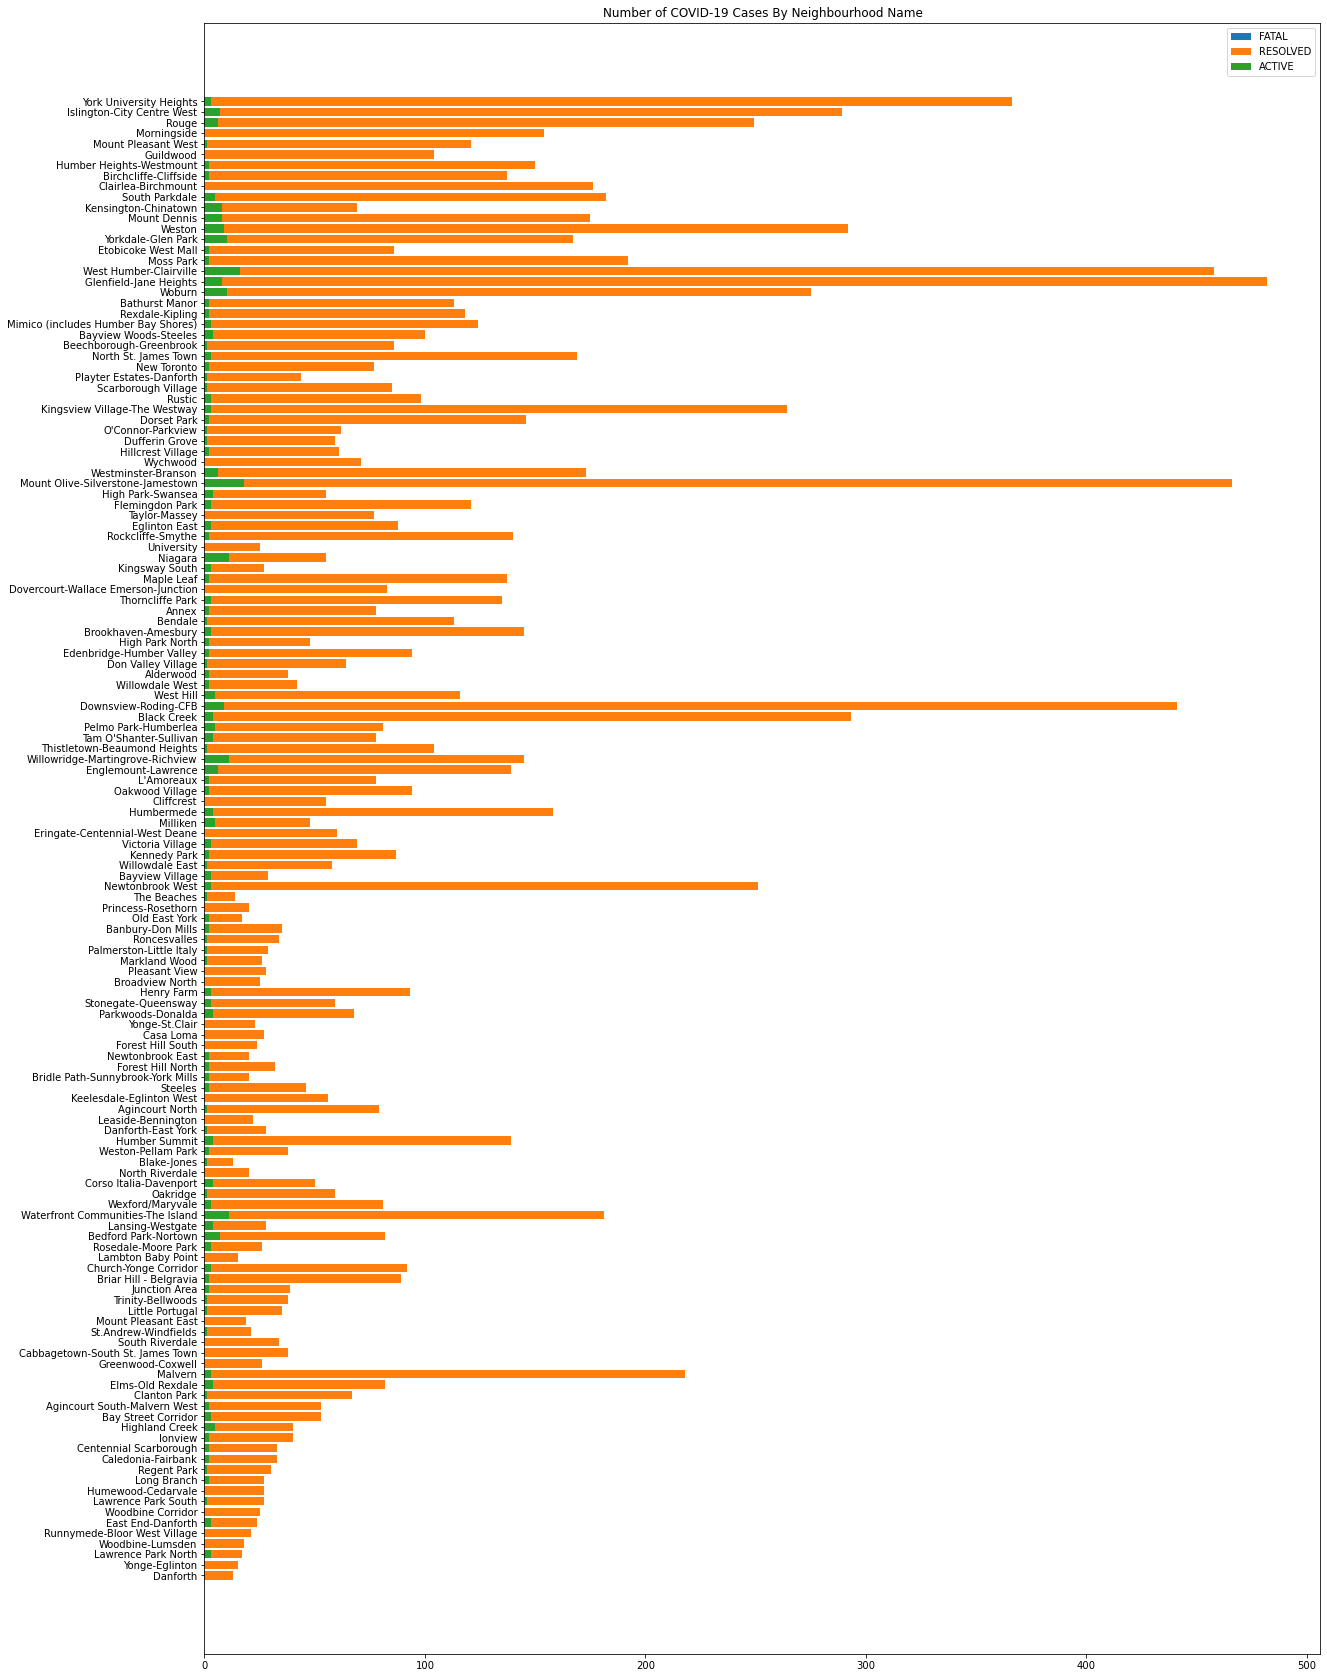

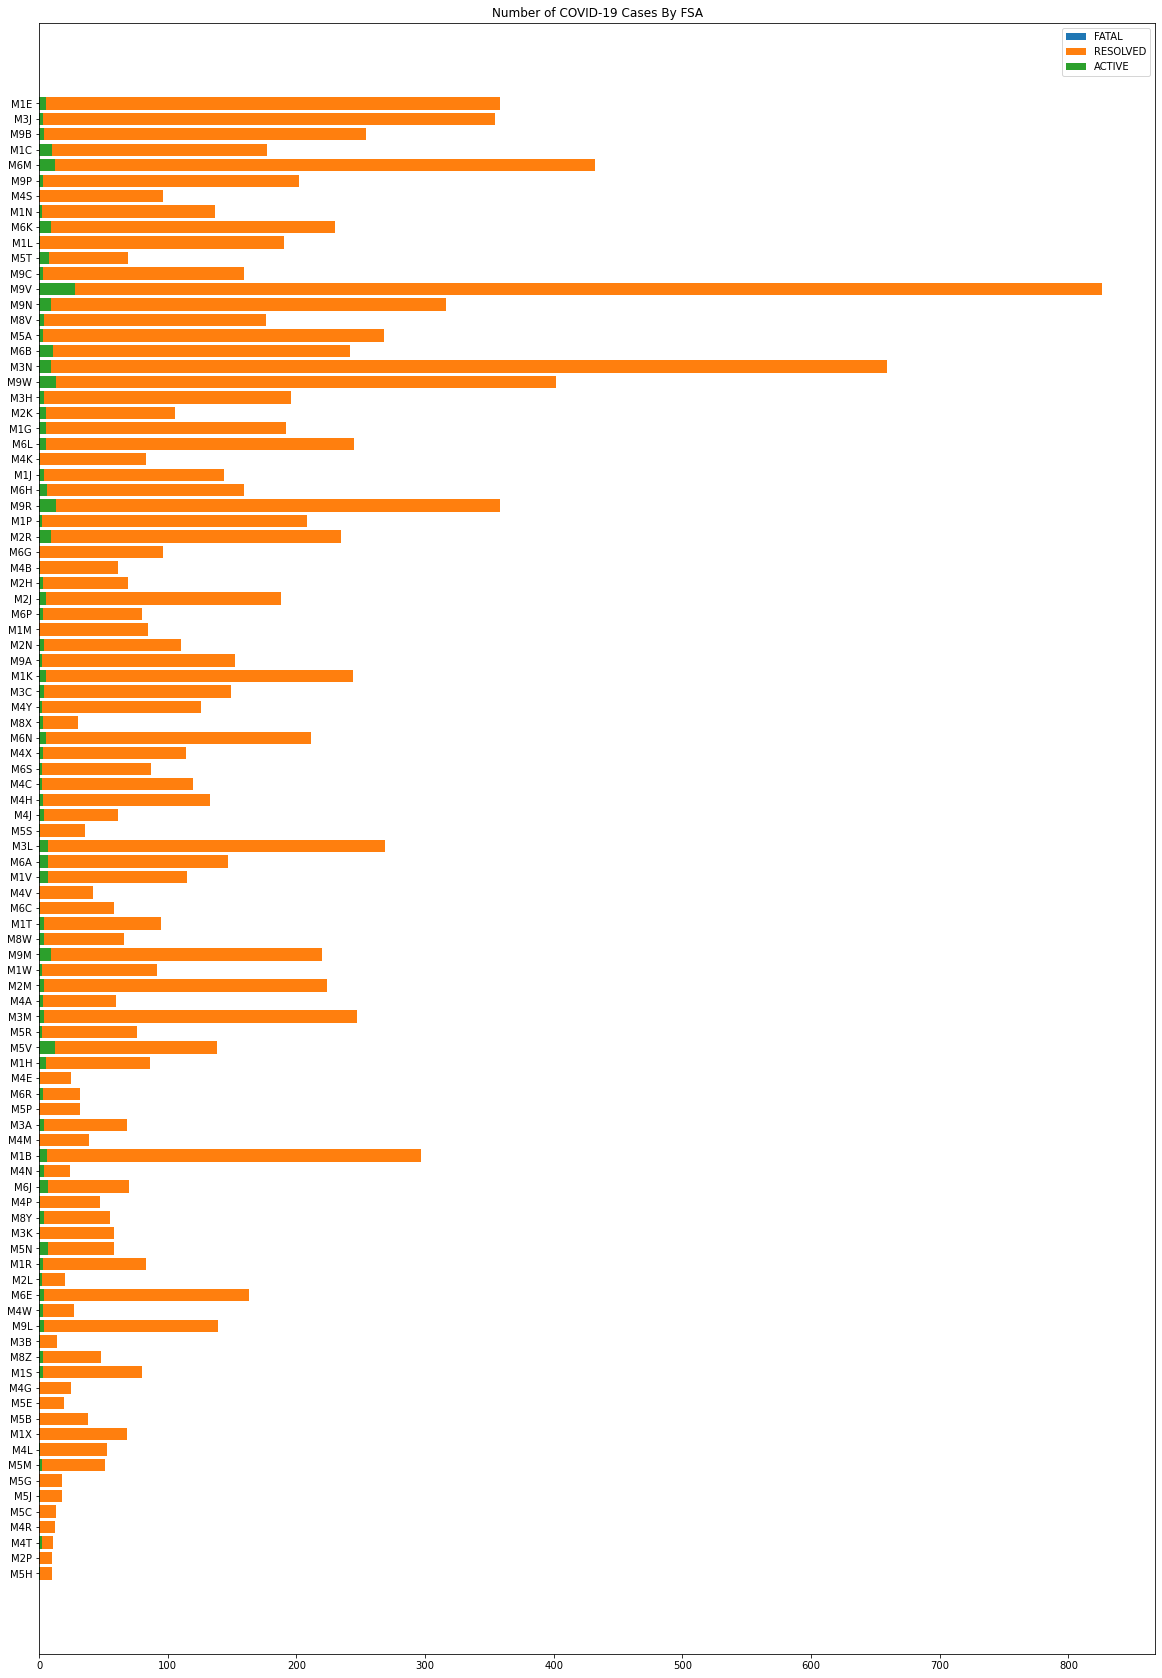

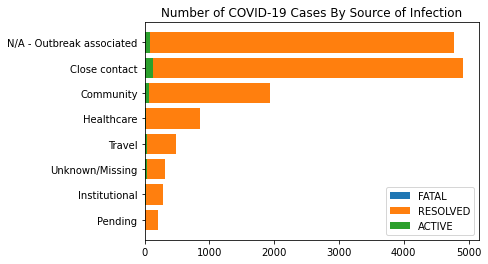

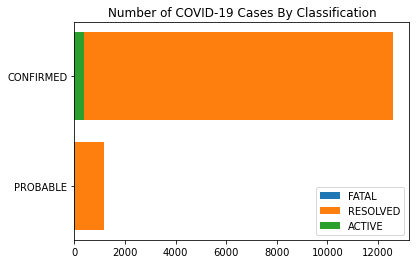

sort flag yes
sort flag yes
sort flag yes


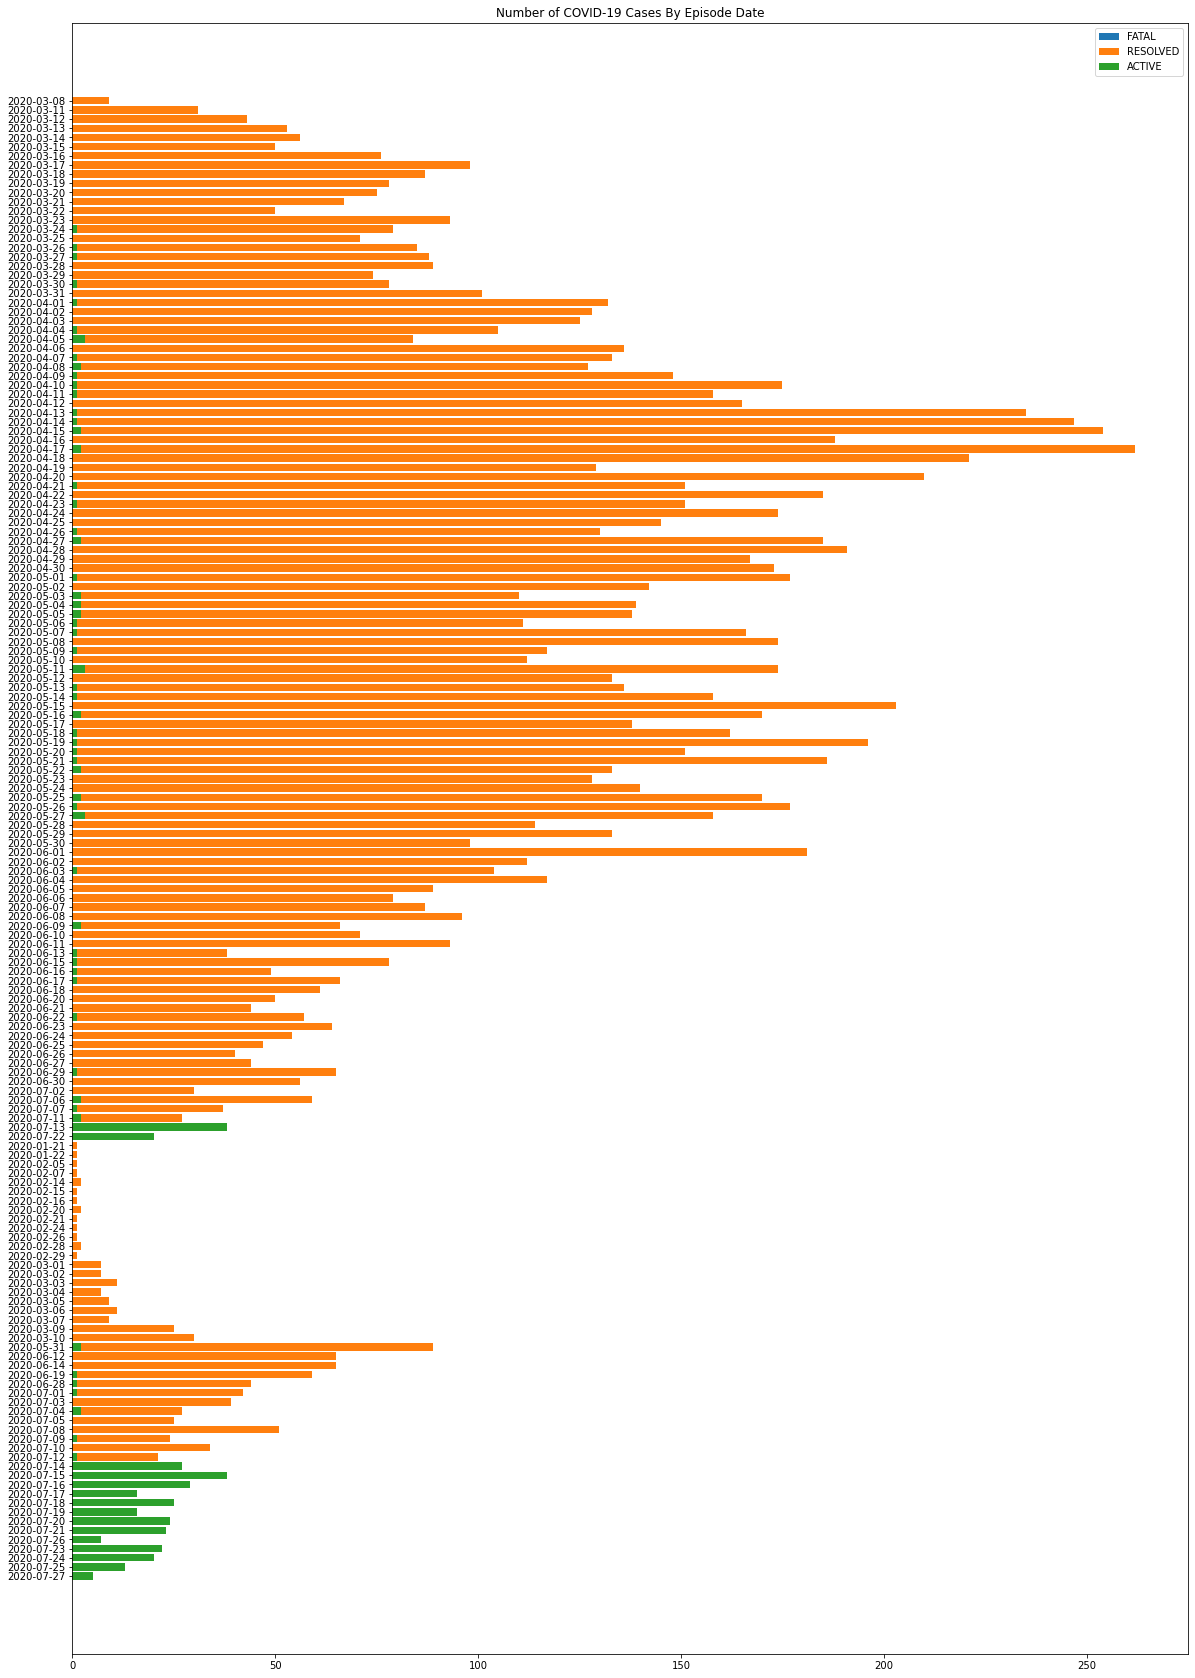

sort flag yes
sort flag yes
sort flag yes


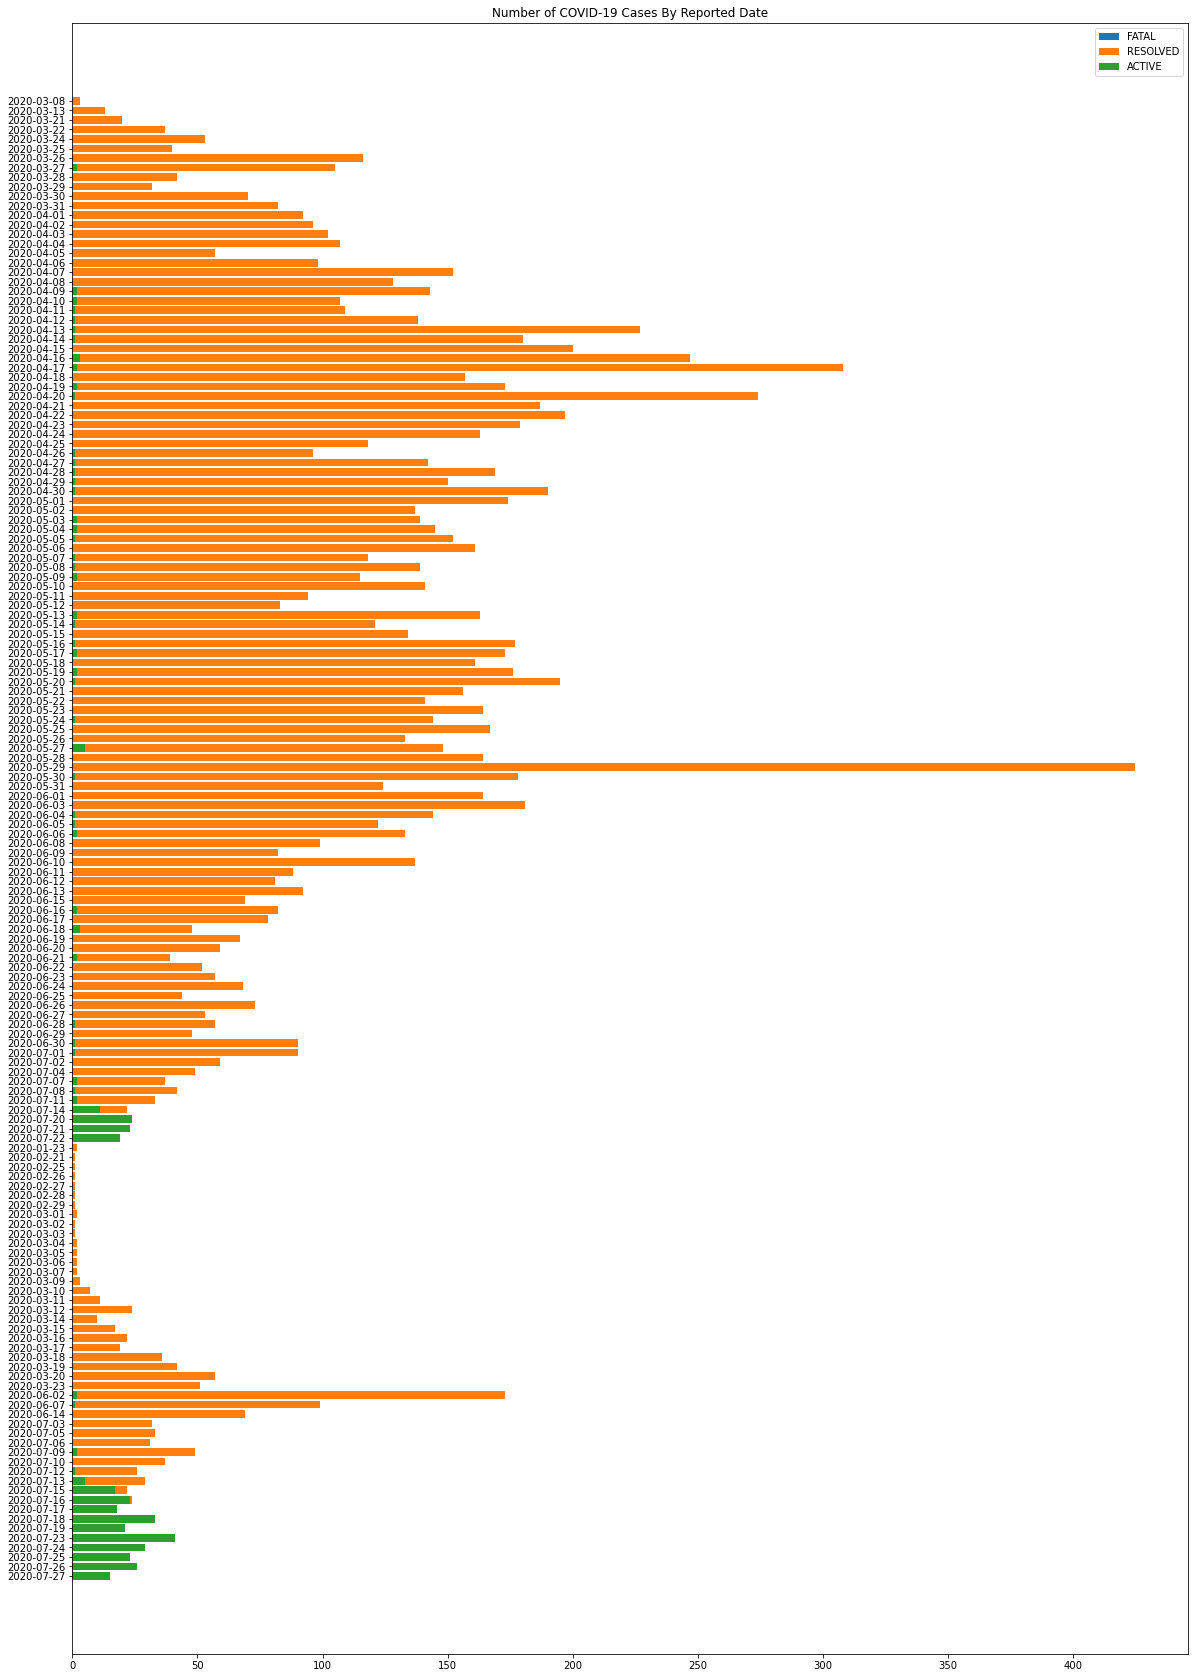

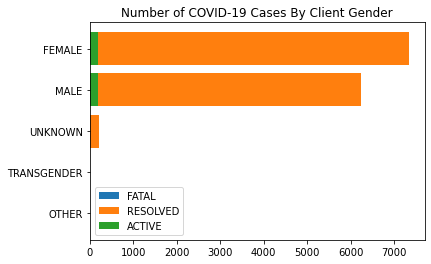

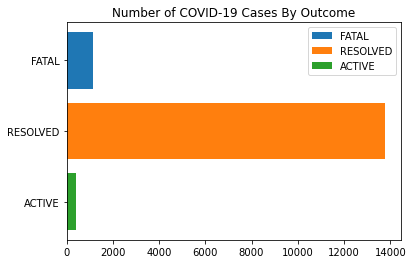

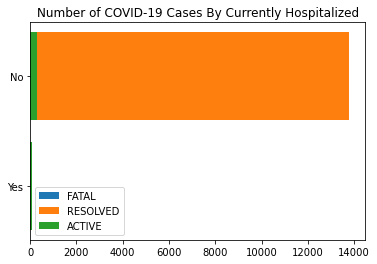

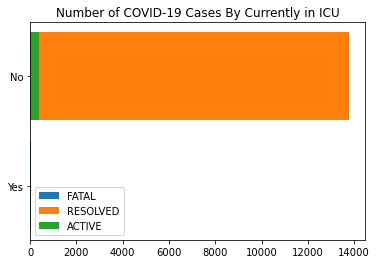

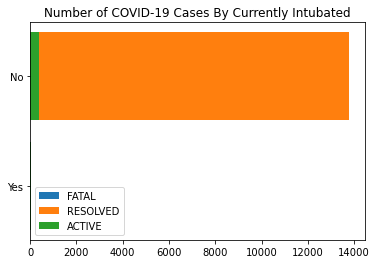

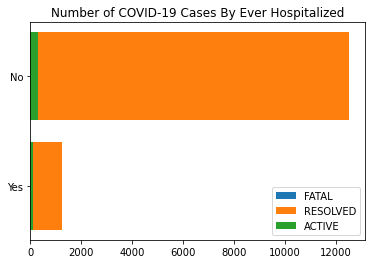

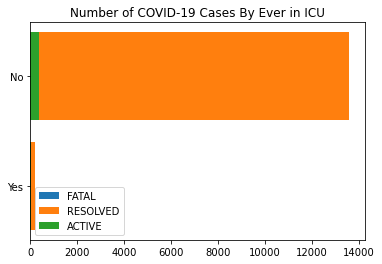

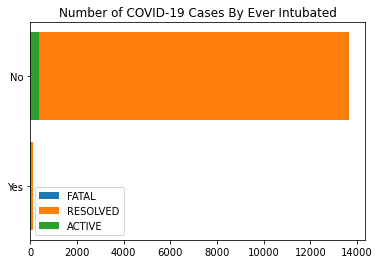

In [65]:
# Put the column names of the dataset into a list
columns = list(covid_data.columns)

# Remove the first two column names (the IDs) because I don't need to graph them
columns_no_IDs = columns[2:]

# Column to be filtered
filter_column = 'Outcome'
# Entries to be filtered
filter_entry_list = ['FATAL', 'RESOLVED', 'ACTIVE']

# Create bar charts for relevant columns
for column in columns_no_IDs:
    #create_bar_chart(column)
    # Figure size
    if column == 'Neighbourhood Name' or column == 'FSA' or column == 'Episode Date' or column == 'Reported Date':
        fig_size = 'large'
    else:
        fig_size = 'normal'
    
    #Sort values
    if column == 'Episode Date' or column == 'Reported Date':
        sort_flag = 'yes'
    else:
        sort_flag = 'no'
    create_filtered_bar_chart(column, filter_column, filter_entry_list, fig_size, sort_flag)

# Sort doesn't work properly
# Remove the first two column names (the IDs) because I don't need to graph them
columns_no_IDs = columns[2:]

# Column to be filtered
filter_column = 'Outcome'
# Entries to be filtered
filter_entry_list = ['FATAL', 'RESOLVED', 'ACTIVE']

# Create bar charts for relevant columns
for column in columns_no_IDs:
    #create_bar_chart(column)
    
    fig = plt.figure(figsize=(20,30))
    # For locations, order from highest to lowest count
    if column == 'Neighbourhood Name' or 'FSA':
        sort_flag = 'n'
        # Make the figure bigger
        #fig = plt.figure(figsize=(20,30))  
    # For dates, order the labels by date instead of by value count
    elif column == 'Episode Date' or 'Reported Date':
        sort_flag = 'y'
        # Make the figure bigger
        #fig = plt.figure(figsize=(20,30))
    # For other columns
    else:
        sort_flag = 'n'
        # Normal-sized figure
        #fig = plt.figure()
    create_filtered_bar_chart(column, filter_column, filter_entry_list, sort_flag)

The fatal cases make up 7.5% of total cases. As the number of resolved cases is an order of a magnitude higher, it is difficult to see the fatal cases in the bar charts. I will graph only the fatal cases below.

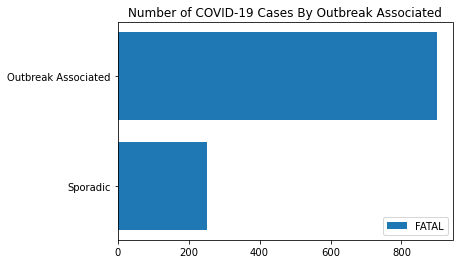

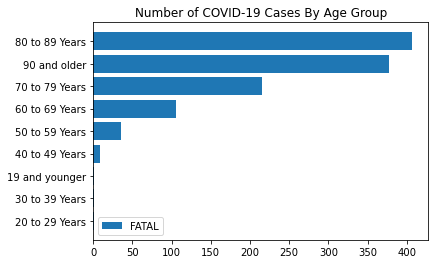

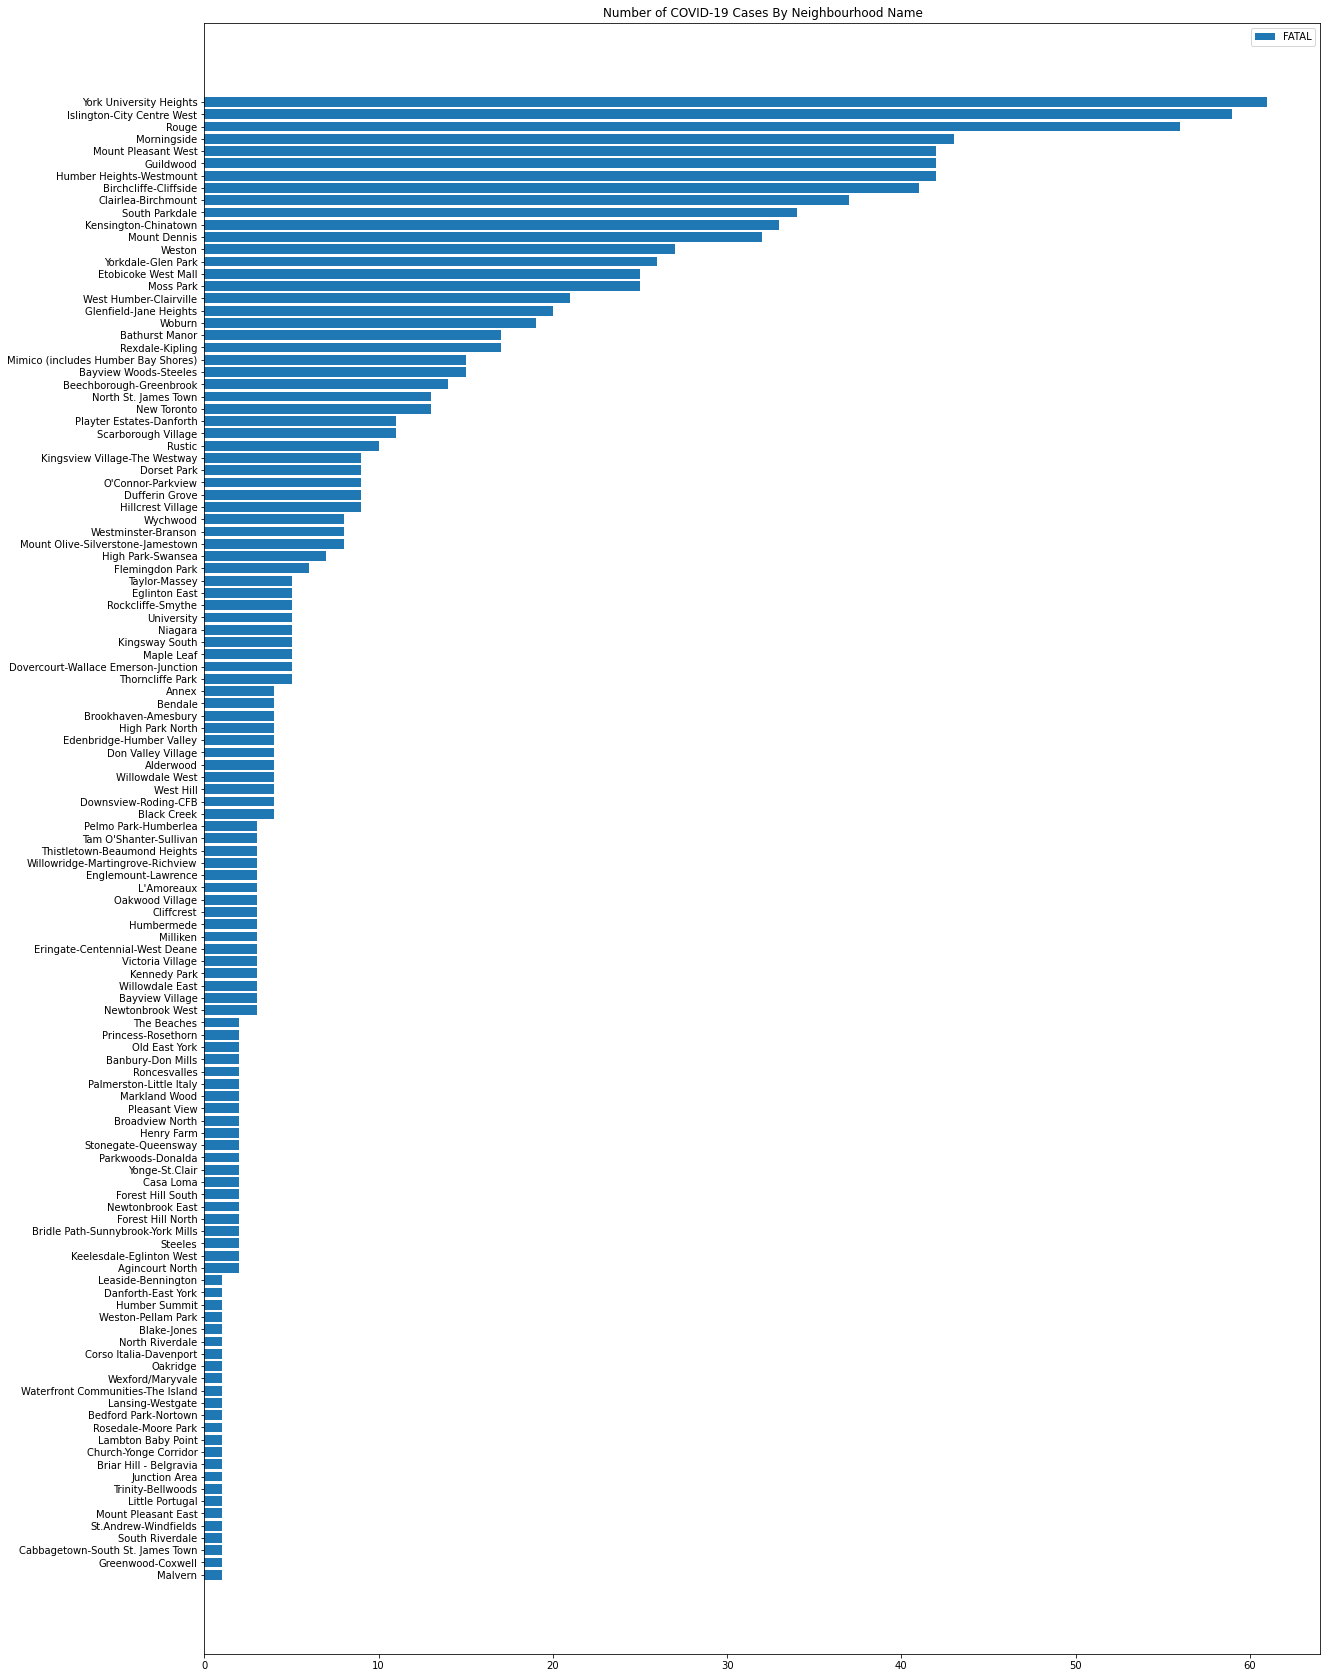

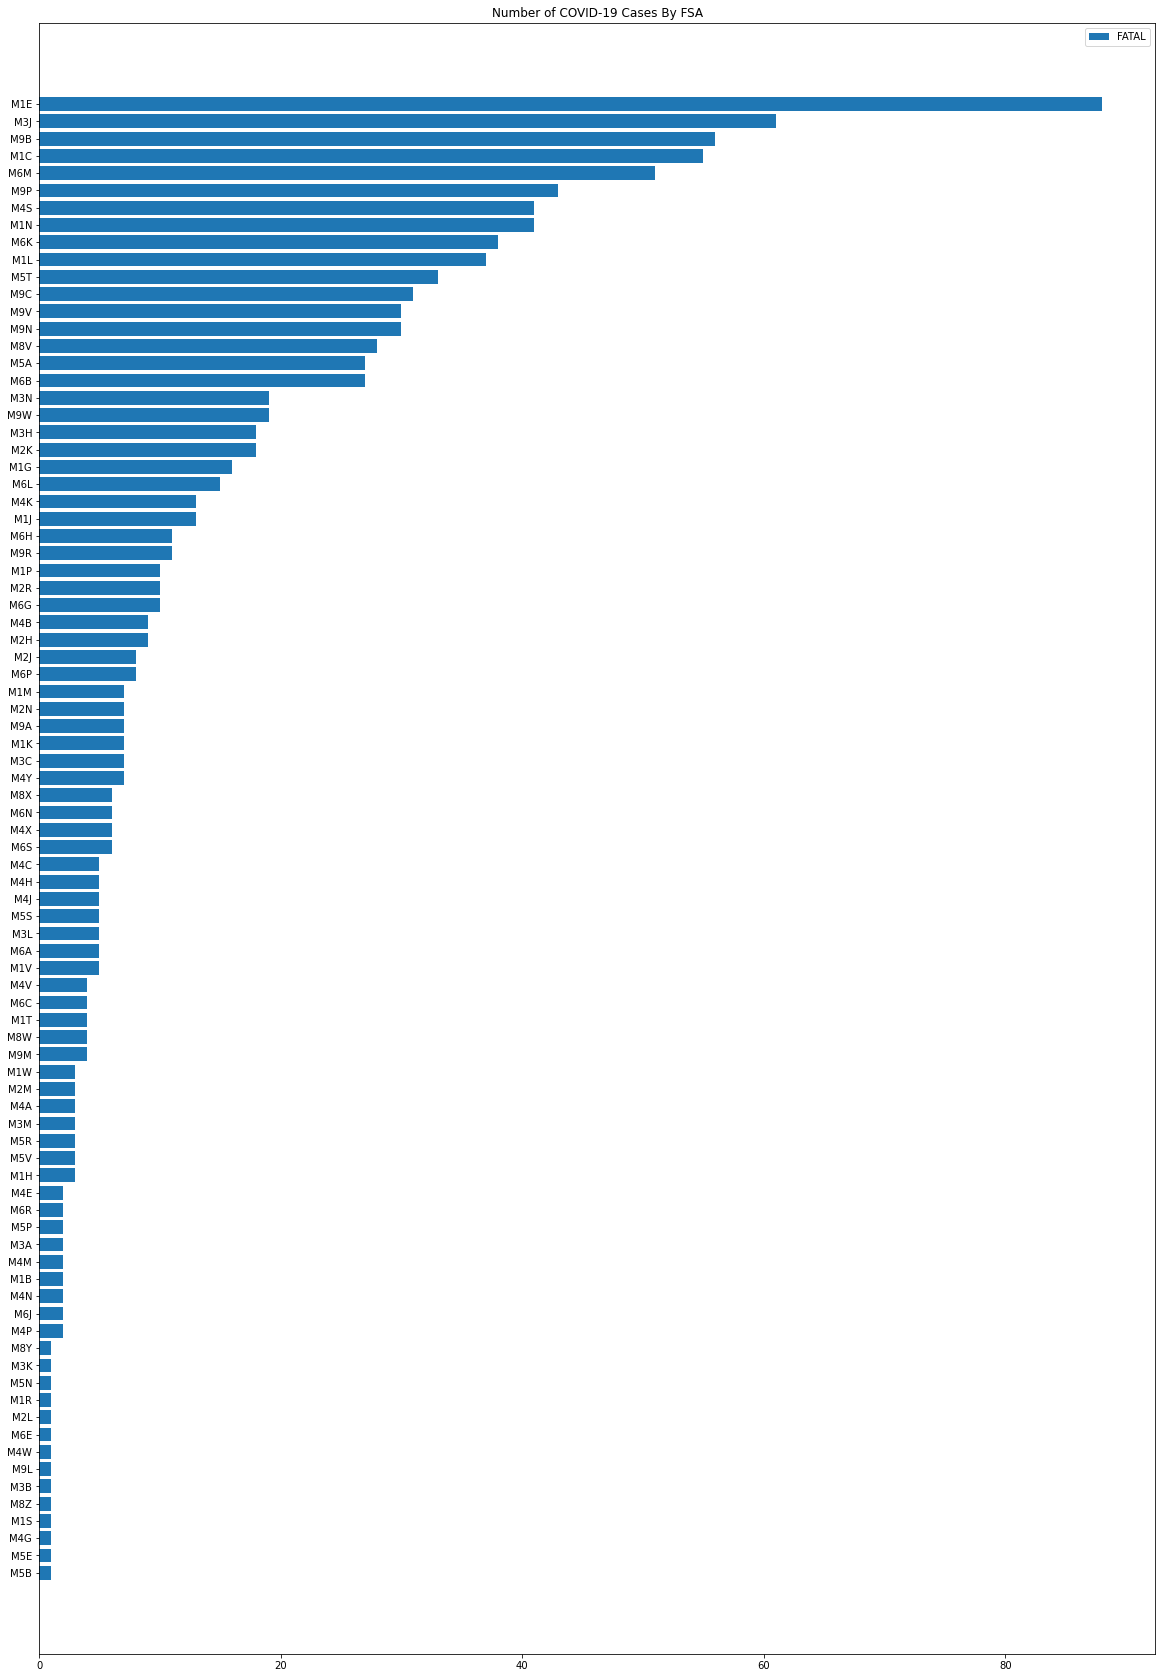

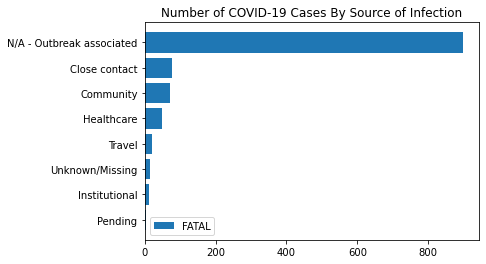

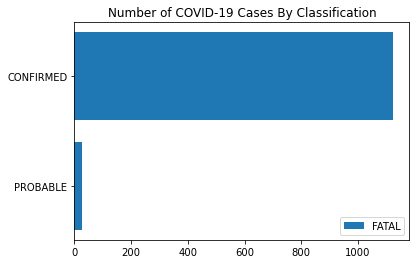

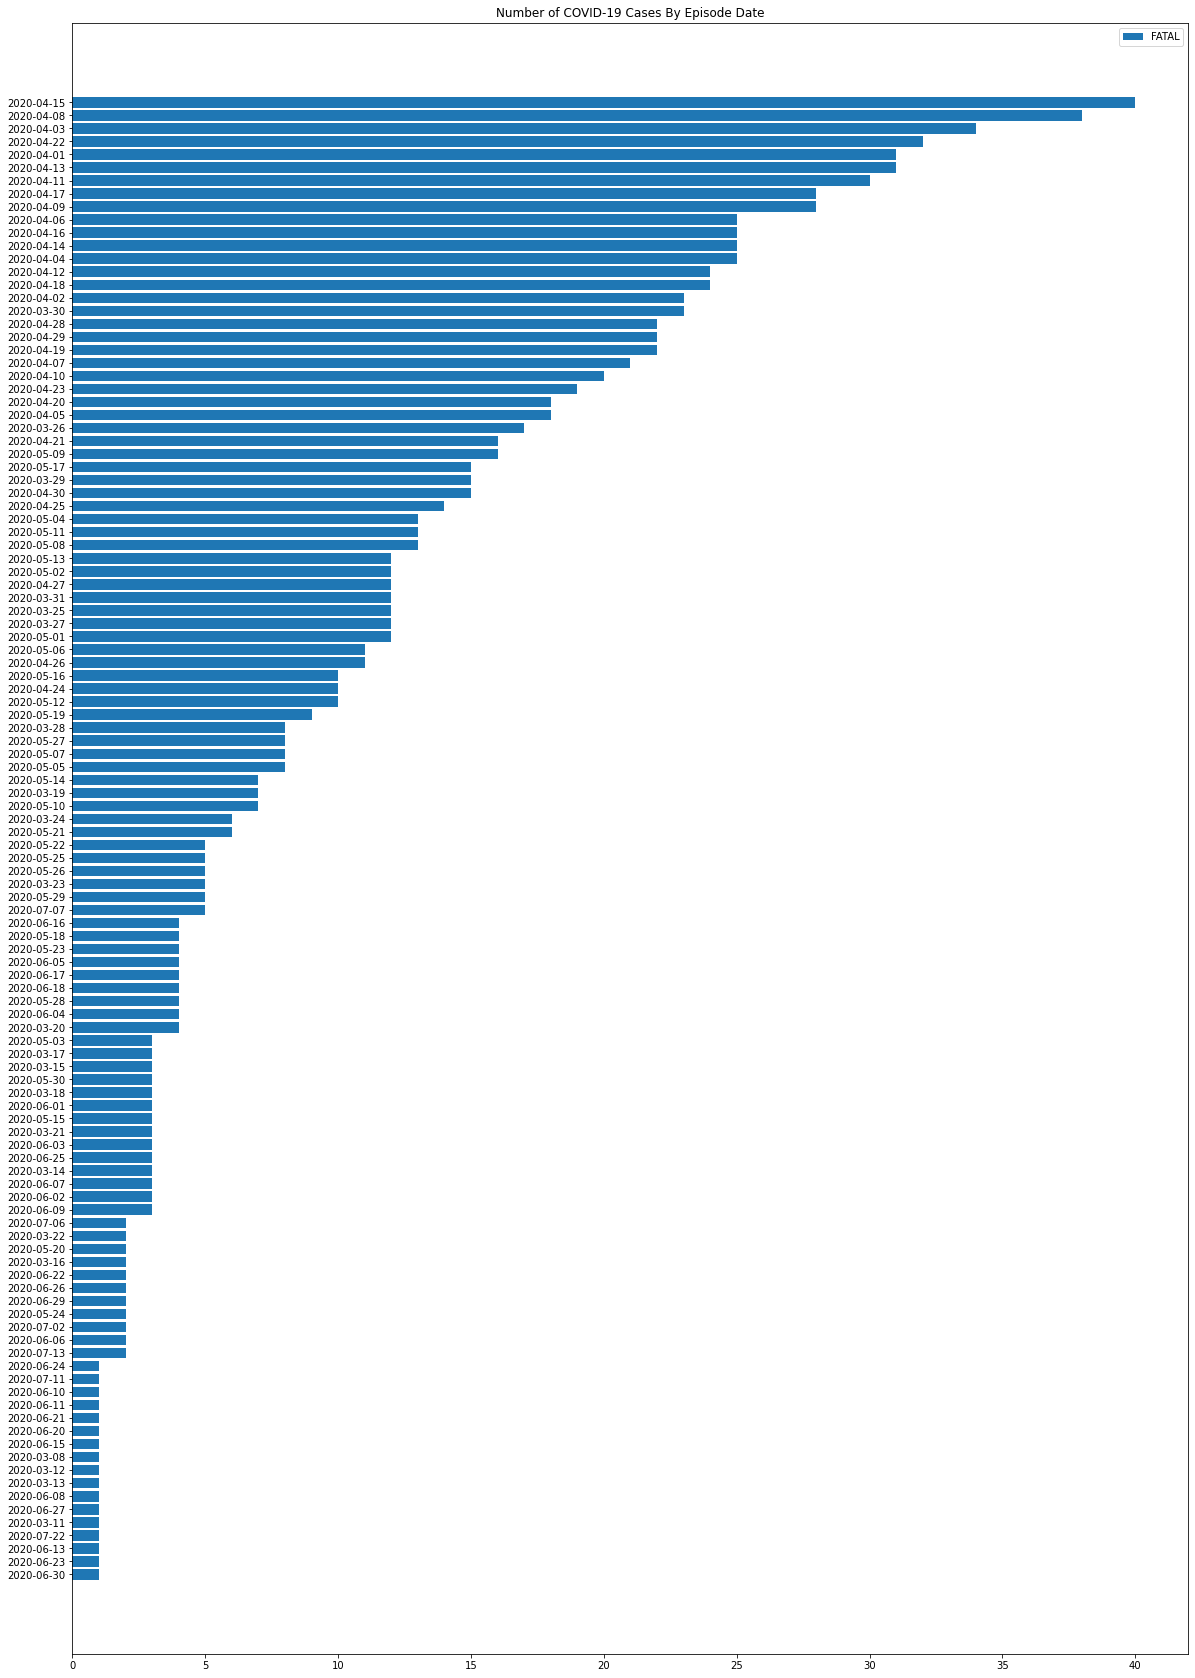

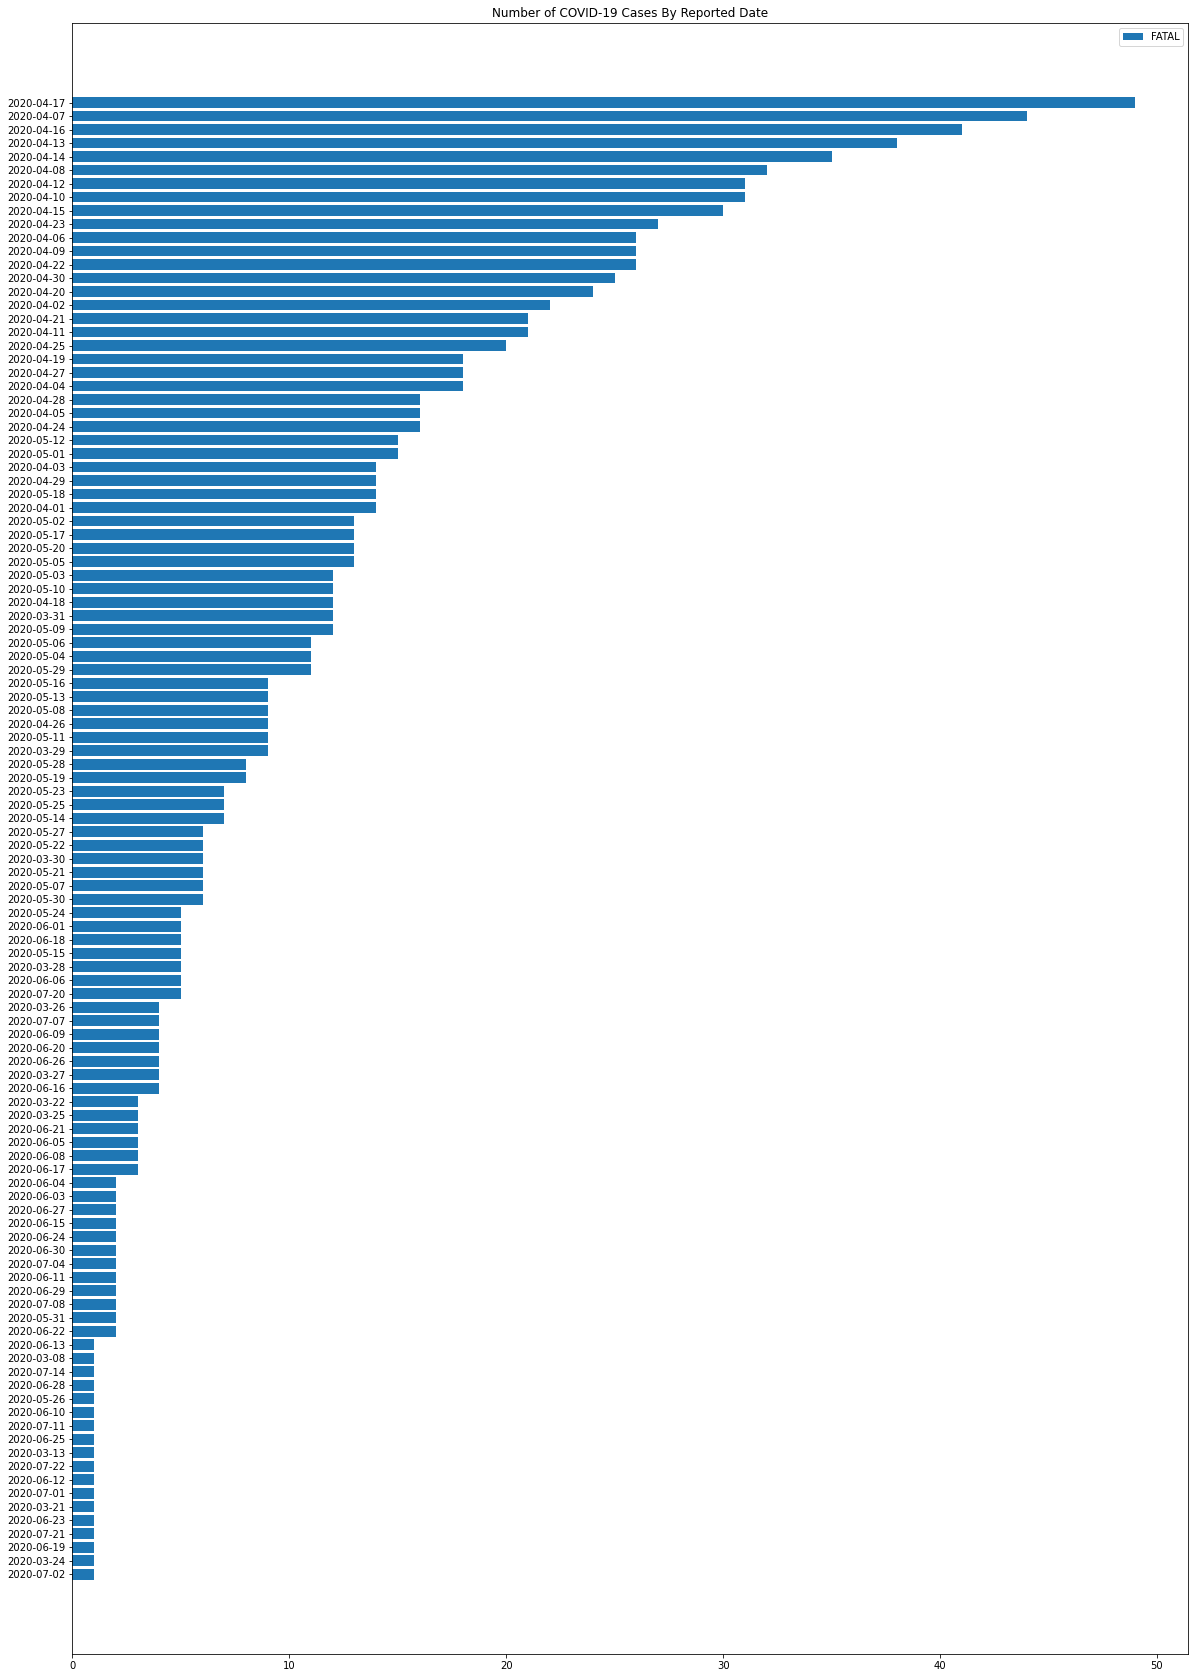

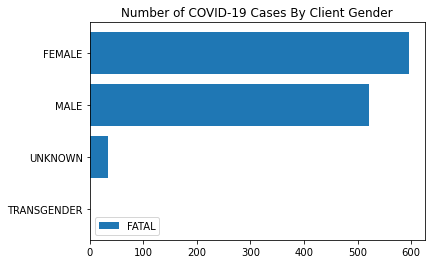

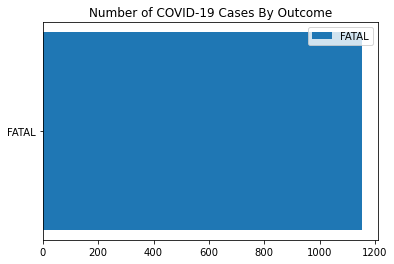

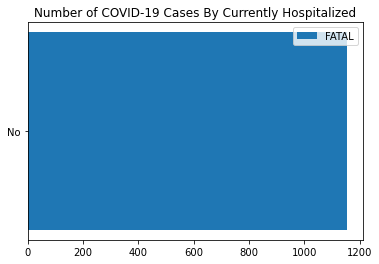

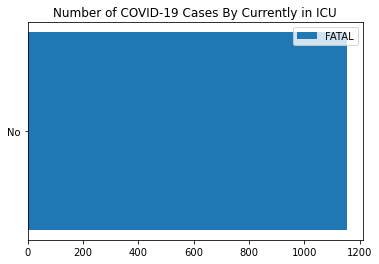

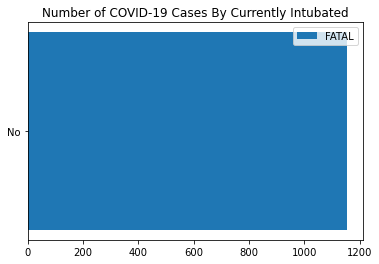

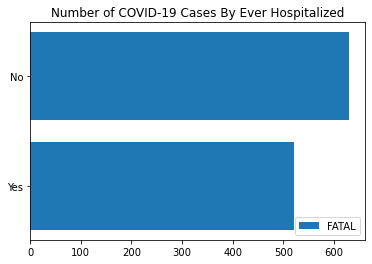

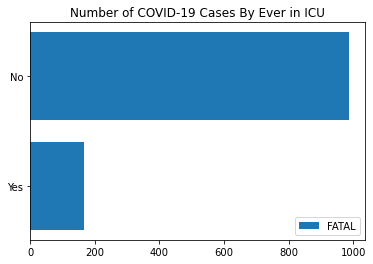

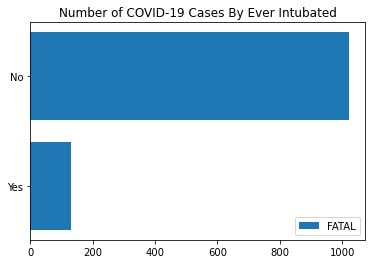

In [66]:
# Only filter fatal outcomes
filter_entry_list = ['FATAL']

# Create bar charts for relevant columns
for column in columns_no_IDs:
    #create_bar_chart(column)
    # Figure size
    if column == 'Neighbourhood Name' or column == 'FSA' or column == 'Episode Date' or column == 'Reported Date':
        fig_size = 'large'
    else:
        fig_size = 'normal'
    create_filtered_bar_chart(column, filter_column, filter_entry_list, fig_size, sort_flag)

In [67]:
# Neighbourhood heat map
# Based on Mukund Vemuri's tutorial: https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55

# Neighbourhood data
nhood_file = '/Neighbourhoods/Neighbourhoods.shp'
#nhoods = gpd.read_file(nhood_file)
#nhoods.sample(5)